In [1]:
import os
from IPython.display import display,Audio,HTML
import scipy.io.wavfile as wav
import numpy as np
import speechpy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import xgboost as xgb
from sklearn import metrics
sns.set()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def extract_features(signal, fs):
    frames = speechpy.processing.stack_frames(signal, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01, filter=lambda x: np.ones((x,)),zero_padding=True)
    power_spectrum = speechpy.processing.power_spectrum(frames, fft_points=1)
    logenergy = speechpy.feature.lmfe(signal, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,num_filters=1, fft_length=512, low_frequency=0, high_frequency=None)
    mfcc = speechpy.feature.mfcc(signal, sampling_frequency=fs, frame_length=0.020, frame_stride=0.01,num_filters=1, fft_length=512, low_frequency=0, high_frequency=None)
    mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
    mfcc_feature_cube = speechpy.feature.extract_derivative_feature(mfcc)
    return np.hstack([power_spectrum[:,0],logenergy[:,0],mfcc_cmvn[:,0],mfcc_feature_cube[:,0,1]])

def extract_files(folder):
    location = folder + '/'
    elements = os.listdir(location)
    results = []
    for i in elements:
        try:
            fs, signal = wav.read(location+i)
            results.append([folder]+extract_features(signal, fs).tolist())
        except:
            continue
    return results

In [3]:
folders = [i for i in os.listdir(os.getcwd())if i.find('.md') < 0 and i.find('.txt') < 0 and i.find('ipynb') < 0 and i.find('LICENSE') < 0]

In [4]:
output = []
for i in folders:
    print(i)
    output += extract_files(i)

yes
marvin
off
happy
bed
house
up
six
go
four
nine
left
no
three
wow
sheila
_background_noise_


/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


right
on
five
seven
zero
stop
one
down
bird


/usr/local/lib/python3.5/dist-packages/speechpy/processing.py:239: RuntimeWarning: divide by zero encountered in true_divide
  variance_normalized[i, :] = mean_subtracted[i, :] / window_variance


tree
eight
dog
two
cat


In [5]:
output = [i for i in output if len(i) == 397]

In [6]:
dataset=np.array(output)
np.random.shuffle(dataset)

In [7]:
print(np.unique(dataset[:,0]).tolist())
target = LabelEncoder().fit_transform(dataset[:,0])

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(dataset[:, 1:], target, test_size = 0.2)

In [9]:
params_lgd = {
    'boosting_type': 'dart',
    'objective': 'multiclass',
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'silent': False,
    'n_estimators': 10000,
    'reg_lambda': 0.0005,
    'device':'gpu'
    }
clf = lgb.LGBMClassifier(**params_lgd)
lasttime = time.time()
clf.fit(train_X,train_Y, eval_set=[(train_X,train_Y), (test_X,test_Y)], 
        eval_metric='logloss', early_stopping_rounds=20, verbose=False)
print('time taken to fit lgb:', time.time()-lasttime, 'seconds ')

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


time taken to fit lgb: 223.1440589427948 seconds 


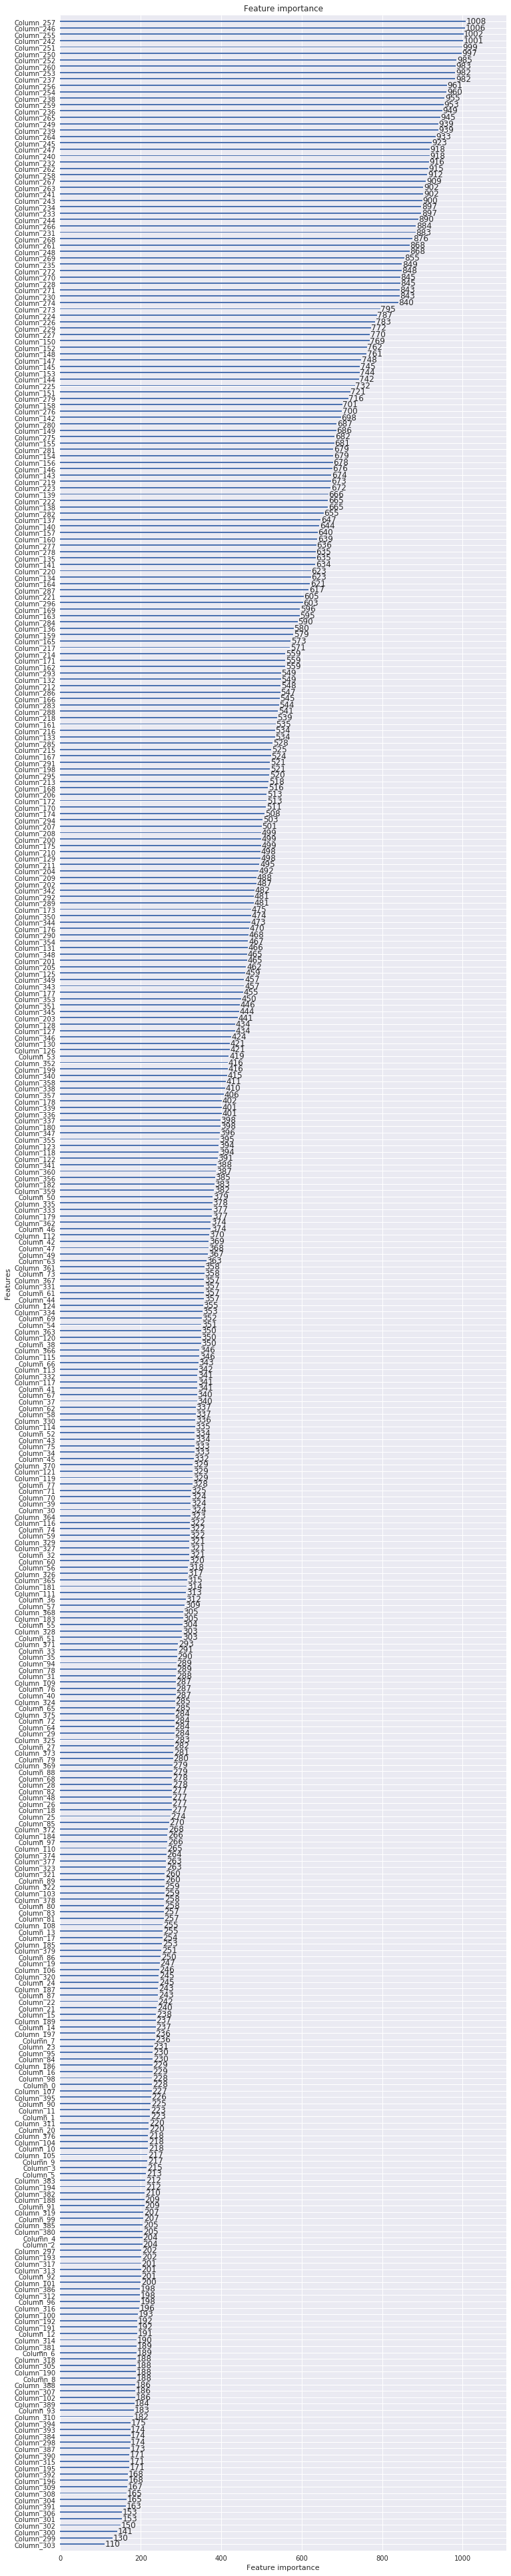

In [10]:
fig, ax = plt.subplots(figsize=(12,70))
lgb.plot_importance(clf, ax=ax)
plt.show()

In [11]:
predicted = clf.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))

# print scores
print(metrics.classification_report(test_Y, predicted, target_names = np.unique(dataset[:,0]).tolist()))

accuracy validation set:  0.34451978371
             precision    recall  f1-score   support

        bed       0.22      0.12      0.16       295
       bird       0.22      0.09      0.12       316
        cat       0.33      0.25      0.28       285
        dog       0.24      0.07      0.11       317
       down       0.23      0.18      0.20       445
      eight       0.34      0.35      0.34       458
       five       0.27      0.25      0.26       412
       four       0.25      0.28      0.26       440
         go       0.17      0.12      0.14       417
      happy       0.60      0.68      0.63       309
      house       0.53      0.33      0.41       327
       left       0.41      0.44      0.42       458
     marvin       0.55      0.56      0.56       318
       nine       0.27      0.43      0.33       403
         no       0.25      0.23      0.24       433
        off       0.33      0.41      0.36       442
         on       0.22      0.29      0.25       397
     

In [12]:
params_xgd = {
    'min_child_weight': 10.0,
    'max_depth': 7,
    'objective': 'multi:softprob',
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'gamma': 0.65,
    'nthread': -1,
    'silent': False,
    'n_estimators': 10000
    }
clf = xgb.XGBClassifier(**params_xgd)
lasttime = time.time()
clf.fit(train_X,train_Y, eval_set=[(train_X,train_Y), (test_X,test_Y)], 
        eval_metric='mlogloss', early_stopping_rounds=20, verbose=False)
print('time taken to fit xgb:', time.time()-lasttime, 'seconds ')

time taken to fit xgb: 6093.673967838287 seconds 


In [13]:
predicted = clf.predict(test_X)
print('accuracy validation set: ', np.mean(predicted == test_Y))

# print scores
print(metrics.classification_report(test_Y, predicted, target_names = np.unique(dataset[:,0]).tolist()))

accuracy validation set:  0.385031327783
             precision    recall  f1-score   support

        bed       0.25      0.18      0.21       295
       bird       0.17      0.11      0.13       316
        cat       0.37      0.34      0.36       285
        dog       0.22      0.14      0.17       317
       down       0.21      0.19      0.20       445
      eight       0.48      0.46      0.47       458
       five       0.33      0.32      0.32       412
       four       0.31      0.33      0.32       440
         go       0.15      0.14      0.15       417
      happy       0.66      0.69      0.68       309
      house       0.59      0.46      0.52       327
       left       0.47      0.45      0.46       458
     marvin       0.60      0.60      0.60       318
       nine       0.29      0.41      0.34       403
         no       0.29      0.28      0.29       433
        off       0.38      0.43      0.40       442
         on       0.24      0.28      0.26       397
    

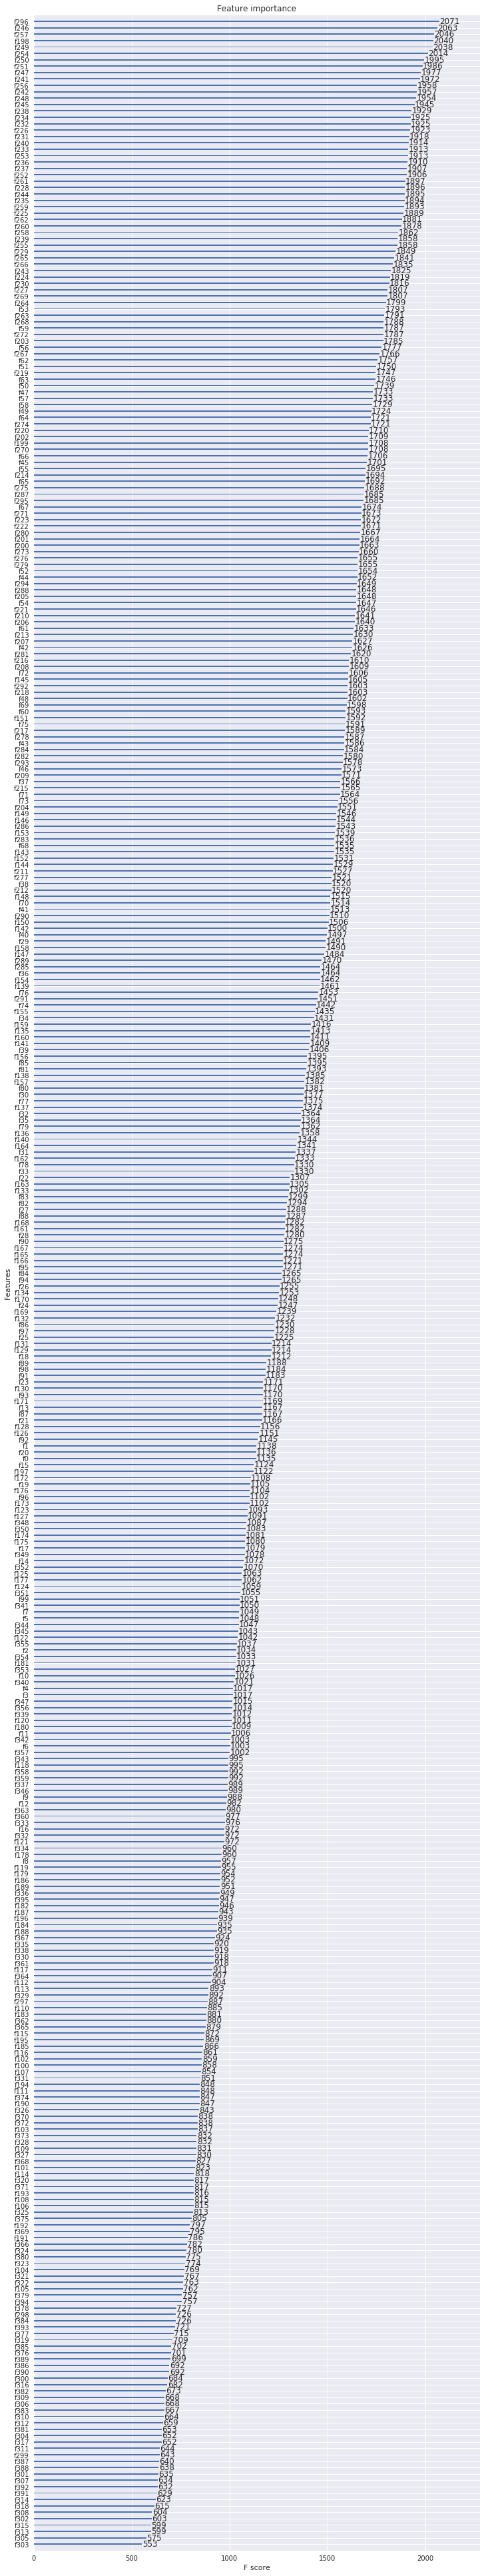

In [20]:
fig, ax = plt.subplots(figsize=(12,70))
xgb.plot_importance(clf, ax=ax)
plt.show()